In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 7.2 MB/s 
     |████████████████████████████████| 168 kB 55.4 MB/s 
     |████████████████████████████████| 182 kB 39.7 MB/s 
     |████████████████████████████████| 62 kB 986 kB/s 
     |████████████████████████████████| 168 kB 26.2 MB/s 
     |████████████████████████████████| 166 kB 57.0 MB/s 
     |████████████████████████████████| 166 kB 65.6 MB/s 
     |████████████████████████████████| 162 kB 71.6 MB/s 
     |████████████████████████████████| 162 kB 60.7 MB/s 
     |████████████████████████████████| 158 kB 52.9 MB/s 
     |████████████████████████████████| 157 kB 63.7 MB/s 
     |████████████████████████████████| 157 kB 63.2 MB/s 
     |████████████████████████████████| 157 kB 30.2 MB/s 
     |████████████████████████████████| 157 kB 26.2 MB/s 
     |████████████████████████████████| 157 kB 52.6 MB/s 
     |████████████████████████████

In [ ]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 7.0 MB/s 


In [ ]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils
from tqdm import tqdm
import wandb
import copy
import random
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler
import time
import copy
from torchvision.utils import save_image

from scipy.io import savemat
from scipy.io import loadmat
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/ProjectB_MT

/content/drive/MyDrive/ProjectB_MT


In [ ]:
from utils import get_dataset, get_network, get_eval_pool, evaluate_synset, get_time, DiffAugment, ParamDiffAug, TensorDataset
from reparam_module import ReparamModule

In [ ]:
parser = argparse.ArgumentParser(description='Parameter Processing')

parser.add_argument('--dataset', type=str, default='CIFAR10', help='dataset')

parser.add_argument('--subset', type=str, default='imagenette', help='ImageNet subset. This only does anything when --dataset=ImageNet')

parser.add_argument('--model', type=str, default='ConvNet', help='model')

parser.add_argument('--ipc', type=int, default=10, help='image(s) per class')

parser.add_argument('--eval_mode', type=str, default='S',
                        help='eval_mode, check utils.py for more info')

parser.add_argument('--num_eval', type=int, default=1, help='how many networks to evaluate on')

parser.add_argument('--eval_it', type=int, default=100, help='how often to evaluate')

parser.add_argument('--epoch_eval_train', type=int, default=20, help='epochs to train a model with synthetic data')
parser.add_argument('--Iteration', type=int, default=100, help='how many distillation steps to perform')

parser.add_argument('--lr_img', type=float, default=1000, help='learning rate for updating synthetic images')
parser.add_argument('--lr_lr', type=float, default=1e-05, help='learning rate for updating... learning rate')
parser.add_argument('--lr_teacher', type=float, default=0.01, help='initialization for synthetic learning rate')

parser.add_argument('--lr_init', type=float, default=0.01, help='how to init lr (alpha)')

parser.add_argument('--batch_real', type=int, default=256, help='batch size for real data')
parser.add_argument('--batch_syn', type=int, default=None, help='should only use this if you run out of VRAM')
parser.add_argument('--batch_train', type=int, default=256, help='batch size for training networks')

parser.add_argument('--pix_init', type=str, default='real', choices=["noise", "real"],
                        help='noise/real: initialize synthetic images from random noise or randomly sampled real images.')

parser.add_argument('--dsa', type=str, default='True', choices=['True', 'False'],
                        help='whether to use differentiable Siamese augmentation.')

parser.add_argument('--dsa_strategy', type=str, default='color_crop_cutout_flip_scale_rotate',
                        help='differentiable Siamese augmentation strategy')

parser.add_argument('--data_path', type=str, default='data', help='dataset path')
parser.add_argument('--buffer_path', type=str, default='./buffers', help='buffer path')

parser.add_argument('--expert_epochs', type=int, default=2, help='how many expert epochs the target params are')
parser.add_argument('--syn_steps', type=int, default=20, help='how many steps to take on synthetic data')
parser.add_argument('--max_start_epoch', type=int, default=2, help='max epoch we can start at')

parser.add_argument('--zca', action='store_true', help="do ZCA whitening")

parser.add_argument('--load_all', action='store_true', help="only use if you can fit all expert trajectories into RAM")

parser.add_argument('--no_aug', type=bool, default=False, help='this turns off diff aug during distillation')

parser.add_argument('--texture', action='store_true', help="will distill textures instead")
parser.add_argument('--canvas_size', type=int, default=2, help='size of synthetic canvas')
parser.add_argument('--canvas_samples', type=int, default=1, help='number of canvas samples per iteration')


parser.add_argument('--max_files', type=int, default=None, help='number of expert files to read (leave as None unless doing ablations)')
parser.add_argument('--max_experts', type=int, default=None, help='number of experts to read per file (leave as None unless doing ablations)')

parser.add_argument('--force_save', action='store_true', help='this will save images for 50ipc')


args, unknown = parser.parse_known_args()
# args.load_all = True


if args.zca and args.texture:
    raise AssertionError("Cannot use zca and texture together")

if args.texture and args.pix_init == "real":
    print("WARNING: Using texture with real initialization will take a very long time to smooth out the boundaries between images.")

if args.max_experts is not None and args.max_files is not None:
    args.total_experts = args.max_experts * args.max_files

print("CUDNN STATUS: {}".format(torch.backends.cudnn.enabled))

args.dsa = True if args.dsa == 'True' else False
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader, loader_train_dict, class_map, class_map_inv = get_dataset(args.dataset, args.data_path, args.batch_real, args.subset, args=args)

im_res = im_size[0]
args.im_size = im_size

if args.dsa:
  
  args.dc_aug_param = None

args.dsa_param = ParamDiffAug()

dsa_params = args.dsa_param
if args.zca:
  zca_trans = args.zca_trans
else:
  zca_trans = None

wandb.init(sync_tensorboard=False,project="DatasetDistillation",job_type="CleanRepo",config=args,)

args = type('', (), {})()

for key in wandb.config._items:
  setattr(args, key, wandb.config._items[key])

args.dsa_param = dsa_params
args.zca_trans = zca_trans


if args.batch_syn is None:
  args.batch_syn = num_classes * args.ipc

args.distributed = torch.cuda.device_count() > 1

print('Hyper-parameters: \n', args.__dict__)

''' organize the real dataset '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]
print("BUILDING DATASET")
for i in tqdm(range(len(dst_train))):
  sample = dst_train[i]
  images_all.append(torch.unsqueeze(sample[0], dim=0))
  labels_all.append(class_map[torch.tensor(sample[1]).item()])

for i, lab in tqdm(enumerate(labels_all)):
  indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args.device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args.device)

for c in range(num_classes):
  print('class c = %d: %d real images'%(c, len(indices_class[c])))

for ch in range(channel):
  print('real images channel %d, mean = %.4f, std = %.4f'%(ch, torch.mean(images_all[:, ch]), torch.std(images_all[:, ch])))


def get_images(c, n):  # get random n images from class c
  idx_shuffle = np.random.permutation(indices_class[c])[:n]
  return images_all[idx_shuffle]

''' initialize the synthetic data '''
label_syn = torch.tensor([np.ones(args.ipc,dtype=np.int_)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

if args.texture:
  image_syn = torch.randn(size=(num_classes * args.ipc, channel, im_size[0]*args.canvas_size, im_size[1]*args.canvas_size), dtype=torch.float)
else:
  image_syn = torch.randn(size=(num_classes * args.ipc, channel, im_size[0], im_size[1]), dtype=torch.float)

syn_lr = torch.tensor(args.lr_teacher).to(args.device)

if args.pix_init == 'real':
  print('initialize synthetic data from random real images')
  if args.texture:
    for c in range(num_classes):
      for i in range(args.canvas_size):
        for j in range(args.canvas_size):
          image_syn.data[c * args.ipc:(c + 1) * args.ipc, :, i * im_size[0]:(i + 1) * im_size[0],
                    j * im_size[1]:(j + 1) * im_size[1]] = torch.cat(
                        [get_images(c, 1).detach().data for s in range(args.ipc)])
  for c in range(num_classes):
    image_syn.data[c * args.ipc:(c + 1) * args.ipc] = get_images(c, args.ipc).detach().data
else:
  print('initialize synthetic data from random noise')


''' training '''
image_syn = image_syn.detach().to(args.device).requires_grad_(True)
syn_lr = syn_lr.detach().to(args.device).requires_grad_(True)
optimizer_img = torch.optim.SGD([image_syn], lr=args.lr_img, momentum=0.5)
optimizer_lr = torch.optim.SGD([syn_lr], lr=args.lr_lr, momentum=0.5)
optimizer_img.zero_grad()

criterion = nn.CrossEntropyLoss().to(args.device)
print('%s training begins'%get_time())

expert_dir = os.path.join(args.buffer_path, args.dataset)
if args.dataset == "ImageNet":
  expert_dir = os.path.join(expert_dir, args.subset, str(args.res))
if args.dataset in ["CIFAR10", "CIFAR100"] and not args.zca:
  expert_dir += "_NO_ZCA"
expert_dir = os.path.join(expert_dir, args.model)
print("Expert Dir: {}".format(expert_dir))

if args.load_all:
  buffer = []
  n = 0
  while os.path.exists(os.path.join(expert_dir, "replay_buffer_{}.pt".format(n))):
        buffer = buffer + torch.load(os.path.join(expert_dir, "replay_buffer_{}.pt".format(n)))
        n += 1
  if n == 0:
    raise AssertionError("No buffers detected at {}".format(expert_dir))

else:
  expert_files = []
  n = 0
  while os.path.exists(os.path.join(expert_dir, "replay_buffer_{}.pt".format(n))):
        expert_files.append(os.path.join(expert_dir, "replay_buffer_{}.pt".format(n)))
        n += 1
  if n == 0:
    raise AssertionError("No buffers detected at {}".format(expert_dir))
  file_idx = 0
  expert_idx = 0
  random.shuffle(expert_files)
  if args.max_files is not None:
    expert_files = expert_files[:args.max_files]
  print("loading file {}".format(expert_files[file_idx]))
  buffer = torch.load(expert_files[file_idx])
  if args.max_experts is not None:
    buffer = buffer[:args.max_experts]
  random.shuffle(buffer)

for it in range(0, args.Iteration+1):
  save_this_it = False
  student_net = get_network(args.model, channel, num_classes, im_size, dist=False).to(args.device)  # get a random model

  student_net = ReparamModule(student_net)

  if args.distributed:
    student_net = torch.nn.DataParallel(student_net)

  student_net.train()

  num_params = sum([np.prod(p.size()) for p in (student_net.parameters())])

  if args.load_all:
    expert_trajectory = buffer[np.random.randint(0, len(buffer))]
  else:
    expert_trajectory = buffer[expert_idx]
    expert_idx += 1
    if expert_idx == len(buffer):
      expert_idx = 0
      file_idx += 1
      if file_idx == len(expert_files):
        file_idx = 0
        random.shuffle(expert_files)
      print("loading file {}".format(expert_files[file_idx]))
      if args.max_files != 1:
        del buffer
        buffer = torch.load(expert_files[file_idx])
      if args.max_experts is not None:
        buffer = buffer[:args.max_experts]
      random.shuffle(buffer)

  start_epoch = np.random.randint(0, args.max_start_epoch)
  starting_params = expert_trajectory[start_epoch]

  target_params = expert_trajectory[start_epoch+args.expert_epochs]
  target_params = torch.cat([p.data.to(args.device).reshape(-1) for p in target_params], 0)

  student_params = [torch.cat([p.data.to(args.device).reshape(-1) for p in starting_params], 0).requires_grad_(True)]

  starting_params = torch.cat([p.data.to(args.device).reshape(-1) for p in starting_params], 0)

  syn_images = image_syn

  y_hat = label_syn.to(args.device)

  param_loss_list = []
  param_dist_list = []
  indices_chunks = []

  for step in range(args.syn_steps):

    if not indices_chunks:
      indices = torch.randperm(len(syn_images))
      indices_chunks = list(torch.split(indices, args.batch_syn))

    these_indices = indices_chunks.pop()


    x = syn_images[these_indices]
    this_y = y_hat[these_indices]

    if args.texture:
      x = torch.cat([torch.stack([torch.roll(im, (torch.randint(im_size[0]*args.canvas_size, (1,)), torch.randint(im_size[1]*args.canvas_size, (1,))), (1,2))[:,:im_size[0],:im_size[1]] for im in x]) for _ in range(args.canvas_samples)])
      this_y = torch.cat([this_y for _ in range(args.canvas_samples)])

    if args.dsa and (not args.no_aug):
      x = DiffAugment(x, args.dsa_strategy, param=args.dsa_param)

    if args.distributed:
      forward_params = student_params[-1].unsqueeze(0).expand(torch.cuda.device_count(), -1)
    else:
      forward_params = student_params[-1]
    x = student_net(x, flat_param=forward_params)
    ce_loss = criterion(x, this_y)

    grad = torch.autograd.grad(ce_loss, student_params[-1], create_graph=True)[0]

    student_params.append(student_params[-1] - syn_lr * grad)


  param_loss = torch.tensor(0.0).to(args.device)
  param_dist = torch.tensor(0.0).to(args.device)

  param_loss += torch.nn.functional.mse_loss(student_params[-1], target_params, reduction="sum")
  param_dist += torch.nn.functional.mse_loss(starting_params, target_params, reduction="sum")

  param_loss_list.append(param_loss)
  param_dist_list.append(param_dist)


  param_loss /= num_params
  param_dist /= num_params

  param_loss /= param_dist

  grand_loss = param_loss

  optimizer_img.zero_grad()
  optimizer_lr.zero_grad()

  grand_loss.backward()

  optimizer_img.step()
  optimizer_lr.step()

  wandb.log({"Grand_Loss": grand_loss.detach().cpu(),
                "Start_Epoch": start_epoch})

  for _ in student_params:
    del _

  if it%10 == 0:
    print('%s iter = %04d, loss = %.4f' % (get_time(), it, grand_loss.item()))
    
    ''' Test '''  
    accs = []
    eval_labs = label_syn
    with torch.no_grad():
      image_save = image_syn
    image_syn_eval, label_syn_eval = copy.deepcopy(image_save.detach()), copy.deepcopy(eval_labs.detach()) # avoid any unaware modification
    args.lr_net = syn_lr.item()
    _, acc_train, acc_test = evaluate_synset(1, get_network(args.model, channel, num_classes, im_size, dist=False).to(args.device), image_syn_eval, label_syn_eval, testloader, args)
    accs.append(acc_test)

wandb.finish()


CUDNN STATUS: True
Files already downloaded and verified
Files already downloaded and verified


Hyper-parameters: 
 {'dataset': 'CIFAR10', 'subset': 'imagenette', 'model': 'ConvNet', 'ipc': 10, 'eval_mode': 'S', 'num_eval': 1, 'eval_it': 100, 'epoch_eval_train': 20, 'Iteration': 100, 'lr_img': 1000, 'lr_lr': 1e-05, 'lr_teacher': 0.01, 'lr_init': 0.01, 'batch_real': 256, 'batch_syn': 100, 'batch_train': 256, 'pix_init': 'real', 'dsa': True, 'dsa_strategy': 'color_crop_cutout_flip_scale_rotate', 'data_path': 'data', 'buffer_path': './buffers', 'expert_epochs': 2, 'syn_steps': 20, 'max_start_epoch': 2, 'zca': False, 'load_all': False, 'no_aug': False, 'texture': False, 'canvas_size': 2, 'canvas_samples': 1, 'max_files': None, 'max_experts': None, 'force_save': False, 'device': 'cuda', 'im_size': [32, 32], 'dc_aug_param': None, 'dsa_param': <utils.ParamDiffAug object at 0x7fda2ba09f10>, '_wandb': {}, 'zca_trans': None, 'distributed': False}
BUILDING DATASET


100%|██████████| 50000/50000 [00:11<00:00, 4185.97it/s]
50000it [00:00, 1770121.97it/s]


class c = 0: 5000 real images
class c = 1: 5000 real images
class c = 2: 5000 real images
class c = 3: 5000 real images
class c = 4: 5000 real images
class c = 5: 5000 real images
class c = 6: 5000 real images
class c = 7: 5000 real images
class c = 8: 5000 real images
class c = 9: 5000 real images
real images channel 0, mean = -0.0000, std = 1.2211
real images channel 1, mean = -0.0002, std = 1.2211
real images channel 2, mean = 0.0002, std = 1.3014
initialize synthetic data from random real images
[2022-12-05 22:22:02] training begins
Expert Dir: ./buffers/CIFAR10_NO_ZCA/ConvNet
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_79.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_40.pt
[2022-12-05 22:22:05] iter = 0000, loss = 0.9434


100%|██████████| 21/21 [00:02<00:00,  8.09it/s]


[2022-12-05 22:22:07] Evaluate_01: epoch = 0020 train time = 2 s train loss = 1.233135 train acc = 0.7400, test acc = 0.2575
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_8.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_12.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_23.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_49.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_95.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_89.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_58.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_91.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_13.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_35.pt
[2022-12-05 22:22:22] iter = 0010, loss = 0.8854


100%|██████████| 21/21 [00:02<00:00,  8.19it/s]


[2022-12-05 22:22:24] Evaluate_01: epoch = 0020 train time = 2 s train loss = 0.751124 train acc = 0.9300, test acc = 0.3094
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_86.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_42.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_1.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_0.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_93.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_54.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_56.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_29.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_16.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_46.pt
[2022-12-05 22:22:39] iter = 0020, loss = 0.8045


100%|██████████| 21/21 [00:02<00:00,  8.27it/s]


[2022-12-05 22:22:42] Evaluate_01: epoch = 0020 train time = 2 s train loss = 1.069109 train acc = 0.7800, test acc = 0.3285
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_78.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_67.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_60.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_92.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_15.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_74.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_85.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_28.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_88.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_26.pt
[2022-12-05 22:22:57] iter = 0030, loss = 0.7737


100%|██████████| 21/21 [00:02<00:00,  8.27it/s]


[2022-12-05 22:23:00] Evaluate_01: epoch = 0020 train time = 2 s train loss = 0.549961 train acc = 0.9700, test acc = 0.3582
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_21.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_66.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_36.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_82.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_65.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_41.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_59.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_27.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_32.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_87.pt
[2022-12-05 22:23:16] iter = 0040, loss = 0.7712


100%|██████████| 21/21 [00:02<00:00,  8.42it/s]


[2022-12-05 22:23:18] Evaluate_01: epoch = 0020 train time = 2 s train loss = 0.806366 train acc = 0.9200, test acc = 0.3584
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_3.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_76.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_18.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_57.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_7.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_2.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_73.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_37.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_34.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_19.pt
[2022-12-05 22:23:34] iter = 0050, loss = 0.6564


100%|██████████| 21/21 [00:02<00:00,  8.13it/s]


[2022-12-05 22:23:36] Evaluate_01: epoch = 0020 train time = 2 s train loss = 0.272168 train acc = 0.9900, test acc = 0.3780
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_94.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_75.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_64.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_9.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_53.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_38.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_68.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_24.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_52.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_25.pt
[2022-12-05 22:23:52] iter = 0060, loss = 0.7065


100%|██████████| 21/21 [00:02<00:00,  8.24it/s]


[2022-12-05 22:23:54] Evaluate_01: epoch = 0020 train time = 2 s train loss = 0.709125 train acc = 0.8500, test acc = 0.4002
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_84.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_81.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_80.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_71.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_14.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_72.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_4.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_98.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_30.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_20.pt
[2022-12-05 22:24:10] iter = 0070, loss = 0.6612


100%|██████████| 21/21 [00:04<00:00,  4.82it/s]


[2022-12-05 22:24:15] Evaluate_01: epoch = 0020 train time = 4 s train loss = 0.313664 train acc = 1.0000, test acc = 0.4174
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_77.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_50.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_31.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_62.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_11.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_47.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_55.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_39.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_90.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_10.pt
[2022-12-05 22:24:31] iter = 0080, loss = 0.6004


100%|██████████| 21/21 [00:02<00:00,  8.13it/s]


[2022-12-05 22:24:33] Evaluate_01: epoch = 0020 train time = 2 s train loss = 0.241216 train acc = 1.0000, test acc = 0.4293
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_61.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_63.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_43.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_97.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_45.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_69.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_17.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_48.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_70.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_44.pt
[2022-12-05 22:24:49] iter = 0090, loss = 0.6311


100%|██████████| 21/21 [00:02<00:00,  8.36it/s]


[2022-12-05 22:24:52] Evaluate_01: epoch = 0020 train time = 2 s train loss = 0.184374 train acc = 1.0000, test acc = 0.4234
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_22.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_96.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_5.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_83.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_33.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_6.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_99.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_51.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_24.pt
loading file ./buffers/CIFAR10_NO_ZCA/ConvNet/replay_buffer_28.pt
[2022-12-05 22:25:07] iter = 0100, loss = 0.5296


100%|██████████| 21/21 [00:02<00:00,  8.18it/s]

[2022-12-05 22:25:10] Evaluate_01: epoch = 0020 train time = 2 s train loss = 0.489121 train acc = 0.9300, test acc = 0.4198


Grand_Loss,█▇▇▇▇▇▆▆▆▆▆▅▅▄▅▄▄▄▄▄▅▅▃▄▃▃▃▃▃▂▂▃▂▃▂▂▁▁▁▁
Start_Epoch,█▁▁████▁▁██▁▁▁█▁▁▁▁▁██▁█▁▁▁██▁▁▁▁█▁▁▁▁▁▁
Grand_Loss,0.52963
Start_Epoch,0


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


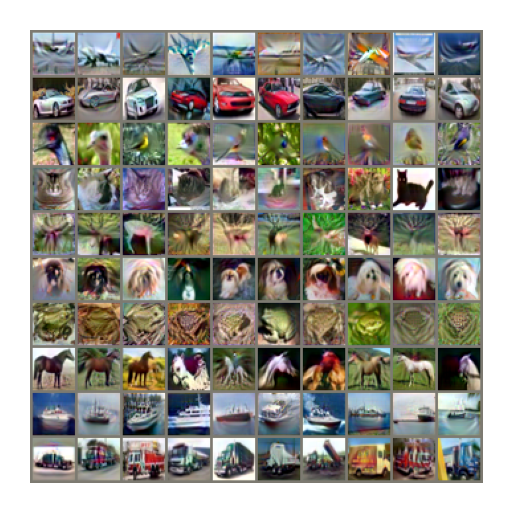

In [ ]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
# images, labels = next(iter(data_loader_train))
dataset_syn = torchvision.utils.make_grid(image_syn, nrow=10).cpu()
dataset_syn = dataset_syn.numpy().transpose(1,2,0)
dataset_syn = dataset_syn*std+mean
print([int(label_syn[i]) for i in range(100)])

plt.figure(dpi=300,figsize=(2,2))
plt.axis('off')
plt.imshow(dataset_syn)
os.chdir('/content/drive/MyDrive/ProjectB/Figures')
plt.savefig('CIFAR10_syn_MT.jpg',dpi=300)
os.chdir('/content/drive/MyDrive/ProjectB/Results')
IMG_dict={'dataset_syn':dataset_syn, 'label_syn':label_syn}
savemat('CIFAR10_syn_MT.mat',IMG_dict)

In [ ]:
data_train = TensorDataset(image_syn.to('cpu'), label_syn.to('cpu'))
trainloader = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True, num_workers=2)
# print(len(data_train))

In [ ]:
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=mean, std=std)])

# data_test = datasets.CIFAR10(root="./data/",
#                transform = transform,
#                train = False)
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader, loader_train_dict, class_map, class_map_inv = get_dataset(args.dataset, args.data_path, args.batch_real, args.subset, args=args)


data_loader_test = torch.utils.data.DataLoader(dataset=dst_test,
                         batch_size = 256,
                         shuffle = True,
                         num_workers=2)

net = get_network('ConvNet', 3 , num_classes = 10, im_size=(32, 32))
net = net.to('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.95)  # optimizer_img for synthetic data
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_net,20)
num_epochs = 20

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# 1000 0.01 2 20 2 40.56%
accuracy_test = []
accuracy_train = []
t_all = 0
for epoch in range(num_epochs):
  net.train(True) # Train mode 
  loss_tot = 0.0
  correct_tot = 0
  print("Epoch {}/{}".format(epoch, num_epochs))
  print("-"*10)
  t0 = time.time()
  for data in trainloader:
    imgs, labels = data
    imgs = imgs.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer_net.zero_grad() # clear the grad
    outputs = net(imgs) # forward
    loss = criterion(outputs,labels) # loss calculation
    pred = torch.argmax(outputs,dim=1)
    loss_tot += loss.data
    correct_tot += torch.sum(pred == labels.data)
    loss.backward()
    optimizer_net.step()
  scheduler.step()
  t1 = time.time()
    
  net.train(False)
  testing_correct = 0
  for data in data_loader_test:
    img_test, label_test = data
    img_test = img_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    label_test = label_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = net(img_test)
    pred = torch.argmax(outputs,dim=1)
    testing_correct += torch.sum(pred == label_test.data)
  accuracy_test.append(100*testing_correct/len(dst_test))
  accuracy_train.append(100*correct_tot/len(data_train))
  print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}%".format(loss_tot/len(data_train),
                                           100*correct_tot/len(data_train),
                                           100*testing_correct/len(dst_test)))
  print("Training time:{:.4f}s".format(t1-t0))
  t_all = t_all+(t1-t0)
print(t_all)

Epoch 0/20
----------
Loss is:0.0238, Train Accuracy is:8.0000%, Test Accuracy is:10.5600%
Training time:0.2055s
Epoch 1/20
----------
Loss is:0.0229, Train Accuracy is:14.0000%, Test Accuracy is:15.6300%
Training time:0.1947s
Epoch 2/20
----------
Loss is:0.0213, Train Accuracy is:28.0000%, Test Accuracy is:20.3700%
Training time:0.1856s
Epoch 3/20
----------
Loss is:0.0195, Train Accuracy is:55.0000%, Test Accuracy is:24.3500%
Training time:0.1957s
Epoch 4/20
----------
Loss is:0.0177, Train Accuracy is:69.0000%, Test Accuracy is:28.2600%
Training time:0.1859s
Epoch 5/20
----------
Loss is:0.0158, Train Accuracy is:81.0000%, Test Accuracy is:31.7300%
Training time:0.1828s
Epoch 6/20
----------
Loss is:0.0140, Train Accuracy is:89.0000%, Test Accuracy is:33.9400%
Training time:0.1924s
Epoch 7/20
----------
Loss is:0.0124, Train Accuracy is:95.0000%, Test Accuracy is:35.5200%
Training time:0.1869s
Epoch 8/20
----------
Loss is:0.0109, Train Accuracy is:96.0000%, Test Accuracy is:36.140

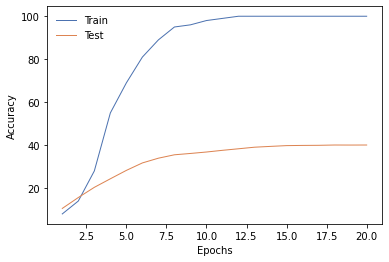

In [ ]:
# Plot the accuracy vs. epochs curve
color_list = sns.color_palette('deep')
accuracy_test = [accuracy_test[i].cpu() for i in range(num_epochs)]
accuracy_train = [accuracy_train[i].cpu() for i in range(num_epochs)]
# plot
plt.plot(range(1,num_epochs+1),accuracy_train,linewidth=1,color = color_list[0],label='Train')
plt.plot(range(1,num_epochs+1),accuracy_test,linewidth=1,color = color_list[1],label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.savefig('/content/drive/MyDrive/ProjectB/Figures/CIFAR10_acc_syn_MT.png',dpi=300)

os.chdir('/content/drive/MyDrive/ProjectB/Results')
IMG_dict={'num_epochs':num_epochs, 'accuracy_test':accuracy_test,'accuracy_train':accuracy_train}
savemat('CIFAR10_acc_syn_MT.mat',IMG_dict)